### Imports

In [255]:
import cv2
import pytesseract
from skimage import io, exposure
from skimage.color import rgb2gray
from skimage.filters import unsharp_mask
from matplotlib.pyplot import imshow, show, hist


### Reading Image

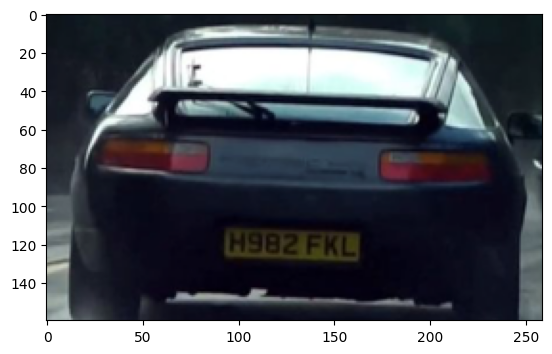

In [256]:
# car_image = io.imread("../dataset/Cars211.png")
car_image = io.imread("../Codes/Cars251.png")
imshow(car_image);

### RGB to GrayScale

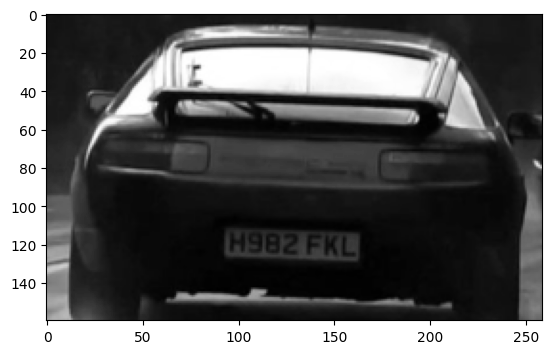

In [257]:
car_image_gray = (rgb2gray(car_image[:,:,:3])*255).astype('uint8')
imshow(car_image_gray, "gray");

### Displaying histogram

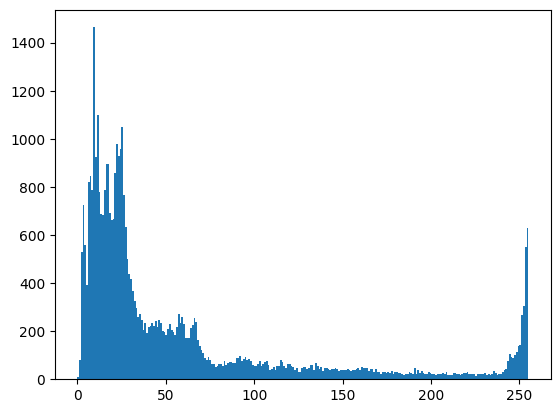

In [258]:
car_image_histogram = exposure.histogram(car_image_gray)[0]
hist(car_image_gray.ravel(),bins=256)
show();

### Determine filter type

In [259]:
# 256 / 2 = 128
# 128 / 2 = 64
# dividing for 4 parts

dark1 = sum(car_image_histogram[0:64])
dark2 = sum(car_image_histogram[64:128])
bright2 = sum(car_image_histogram[128:192])
bright1 = sum(car_image_histogram[192:256])

print(dark1)
print(dark2)
print(bright2)
print(bright1)

# Idea we may iterate more than one time to get good histogram if dark2 + bright2 
# is bigger than bright1 and dark1 

30081
5065
2443
3851


In [260]:
def dark_or_bright():
    if dark1 > bright1:
        if dark1 > dark2 + bright2:
            return 1
    else:
        if bright1 > dark2 + bright2:
            return 0
    return -1
filter_type = dark_or_bright()

### Applying filter

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


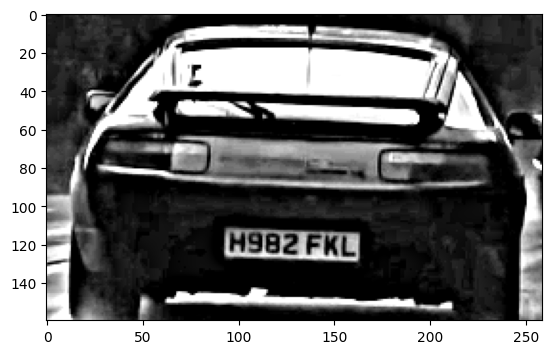

In [261]:
car_image_gray_filtered = car_image_gray.copy()

if (filter_type == 1):
    car_image_gray_filtered = exposure.adjust_log(car_image_gray,gain=0.5)
    car_image_gray_filtered = exposure.equalize_adapthist(car_image_gray_filtered)
    car_image_gray_filtered = unsharp_mask(car_image_gray_filtered, radius=5, amount=2)

else:
    car_image_gray_filtered = exposure.adjust_log(car_image_gray,inv=True,gain=0.5)
    car_image_gray_filtered = exposure.equalize_adapthist(car_image_gray_filtered)
    
io.imsave("car_image_gray_filtered.png",arr=car_image_gray_filtered);
imshow(car_image_gray_filtered,"gray");


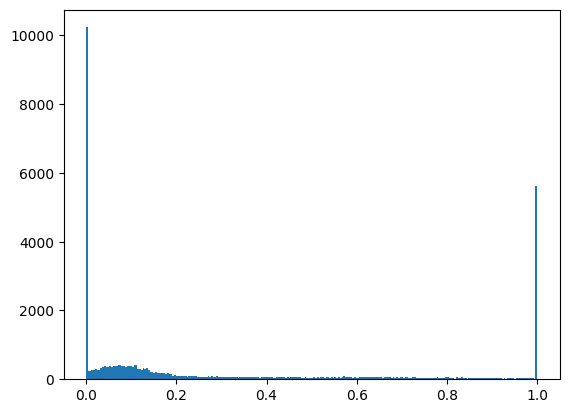

26025
4033
3573
7809


In [262]:
hist(car_image_gray_filtered.ravel(),bins=256)
show();

car_image_histogram = exposure.histogram(car_image_gray_filtered)[0]
 
dark1 = sum(car_image_histogram[0:64])
dark2 = sum(car_image_histogram[64:128])
bright2 = sum(car_image_histogram[128:192])
bright1 = sum(car_image_histogram[192:256])

print(dark1)
print(dark2)
print(bright2)
print(bright1)

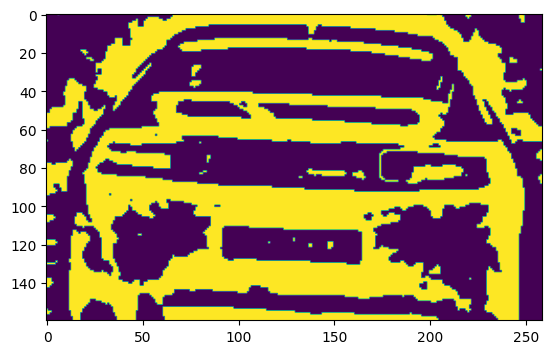

In [263]:
car_image = cv2.imread("../Codes/car_image_gray_filtered.png")
grey_car = cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY)

blur_car = cv2.GaussianBlur(grey_car, (5, 5), 0)
thresh = cv2.adaptiveThreshold(blur_car, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 45, 15)

imshow(thresh);

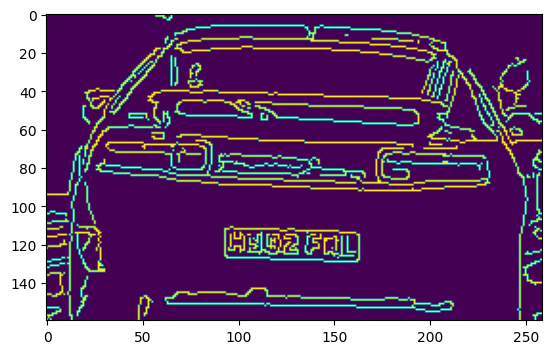

In [264]:
edged = cv2.Canny(blur_car, 30, 200)
imshow(edged);

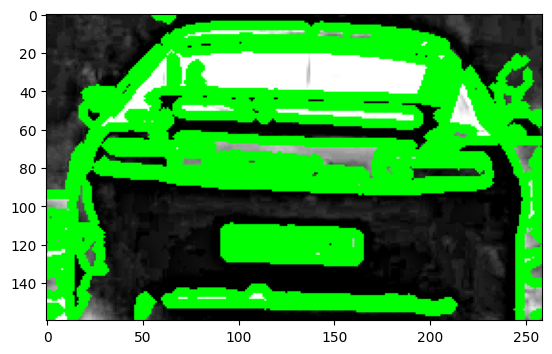

In [265]:
cnts,new = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
car_copy=car_image.copy()
cv2.drawContours(car_copy,cnts,-1,(0,255,0),3)
imshow(car_copy);

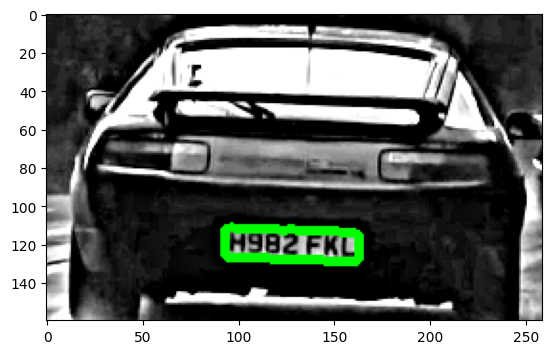

In [266]:
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:1]
screenCnt = None
image2 = car_image.copy()
cv2.drawContours(image2, cnts, -1, (0, 255, 0), 3)
imshow(image2);

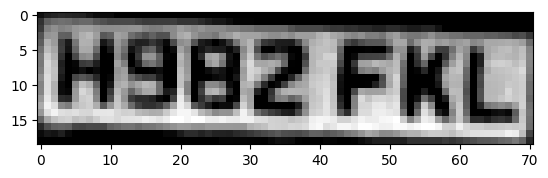

In [267]:
x, y, w, h = cv2.boundingRect(cnts[0])
plate = grey_car[y:y+h, x:x+w]
cv2.imwrite("plate.png", plate)
imshow(plate, "gray");

In [281]:
gray_img = cv2.threshold(plate, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
contours, _ = cv2.findContours(gray_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])
license_plate = ""

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    character_img = gray_img[y:y+h, x:x+w]
    pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
    character = pytesseract.image_to_string(character_img, config='--psm 10 --oem 3 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')
    license_plate += character

print("License Plate:", license_plate)

License Plate: H9B2FKL

